### Import Libraries and Connect to Server

In [1]:
import swat
import dlpy
from dlpy.splitting import two_way_split
from dlpy.applications import *
%matplotlib inline

In [2]:
# Create CAS Connection (GPU)
conn = swat.CAS(host, portnum, protocol='http')

### Load data and view Summary Statistics

In [3]:
# Load the Fruit Image Data
fruit_training_images = dlpy.ImageTable.load_files(conn, path='/anviol/data/fruits')

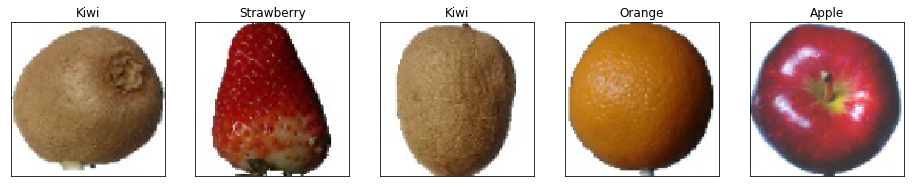

In [4]:
# Preview the Fruit Images
fruit_training_images.show(nimages=5, ncol=5, randomize=True)

In [5]:
# View the Fruit Class Frequency
fruit_training_images.label_freq

,Level,Frequency
Apple,1,490
Banana,2,490
Kiwi,3,466
Mango,4,490
Orange,5,479
Peach,6,492
Pear,7,492
Strawberry,8,492


In [6]:
# View Image Summary
fruit_training_images.image_summary

jpg                  3891
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    127.299
min1stChannel           0
max1stChannel         255
mean2ndChannel    149.465
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     171.91
min3rdChannel           0
max3rdChannel         255
dtype: object

### Data Preparation

In [7]:
# Resize Images to 224x224
fruit_training_images.resize(width=224, height=224, inplace=True)

In [8]:
# Shuffle Images
fruit_training_images.shuffle(casout=dict(name='fruit_training_images', replace=True));

In [9]:
# Split Data into Train / Test
train, test = two_way_split(fruit_training_images, test_rate=20, seed=12345)

### Build Deep Learning Models

In [10]:
# Simple Convolutional Neural Network (CNN)
simple_model = Sequential(conn, model_table='simple_cnn')

simple_model.add(InputLayer(3,224,224, offsets=train.channel_means))

simple_model.add(Conv2d(n_filters=8, width=7, height=7, stride=1, act='relu'))

simple_model.add(Pooling(width=2, height=2, stride=2))

simple_model.add(Conv2d(n_filters=8, width=7, height=7, stride=1, act='relu'))

simple_model.add(Pooling(width=2, height=2))

simple_model.add(Dense(n=16, act='relu'))

simple_model.add(OutputLayer(act='softmax', n=8))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [11]:
# Preview Model Architecture
simple_model.print_summary()

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,Input1,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,Convo.1,convo,"(7, 7)",1,Relu,"(224, 224, 8)","(1176, 8)"
2,Pool1,pool,"(2, 2)",2,Max,"(112, 112, 8)","(0, 0)"
3,Convo.2,convo,"(7, 7)",1,Relu,"(112, 112, 8)","(3136, 8)"
4,Pool2,pool,"(2, 2)",2,Max,"(56, 56, 8)","(0, 0)"
5,F.C.1,fc,"(25088, 16)",None,Relu,16,"(401408, 0)"
6,Output1,output,"(16, 8)",None,Softmax,8,"(128, 8)"
7,,,,,,,405872


In [12]:
# Fit ResNet Deep Learning Model on GPU
simple_model.fit(
            data=train,
            mini_batch_size=16,
            max_epochs=5,
            lr=0.001,
            gpu=dict(devices=[1]),
            n_threads=1,
            log_level=2);

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training from scratch.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 405888.
NOTE:  The approximate memory cost is 128.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.08 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 16.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      8
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple     
NOTE:  Level      1: Banana    
NOTE:  Level      2: Kiwi      
NOTE:  Level      3: Mango     
NOTE:  Level      4: Orange    
NOTE:  Level      5: Peach     
NOTE:  Level      6: Pear      
NOTE:  Level      7:

In [13]:
# Try Common Pre-Built ResNet 50 Model
fruit_model_resnet = ResNet50_Caffe(
                        conn,
                        model_table='resnet50',
                        n_classes=8,
                        n_channels=3,
                        width=224,
                        height=224,
                        scale=1,
                        offsets=train.channel_means,
                        pre_trained_weights=True, 
                        pre_trained_weights_file='anviol/dlWeights/ResNet-50-model.caffemodel.h5',
                        include_top=False)

NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50" according to the model name in the table.


In [14]:
# Fit ResNet Deep Learning Model on GPU
fruit_model_resnet.fit(
                    data=train,
                    mini_batch_size=16,
                    max_epochs=5,
                    lr=0.001,
                    gpu=dict(devices=[1]),
                    n_threads=1,
                    log_level=2);

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 23524488.
NOTE:  The approximate memory cost is 347.00 MB.
NOTE:  Loading weights cost       0.89 (s).
NOTE:  Initializing each layer cost       1.42 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 16.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      8
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple     
NOTE:  Level      1: Banana    
NOTE:  Level      2: Kiwi      
NOTE:  Level      3: Mango     
NOTE:  Level      4: Orange    
NOTE:  Level      5: Peach     
NOTE:  Level      6: Pear      
NOTE:

In [15]:
# View Training History
fruit_model_resnet.training_history

,Epoch,LearningRate,Loss,FitError
0,1,0.001,0.503527,0.077714
1,2,0.001,0.077534,0.000321
2,3,0.001,0.041593,0.000000
3,4,0.001,0.028077,0.000000
4,5,0.001,0.021063,0.000000


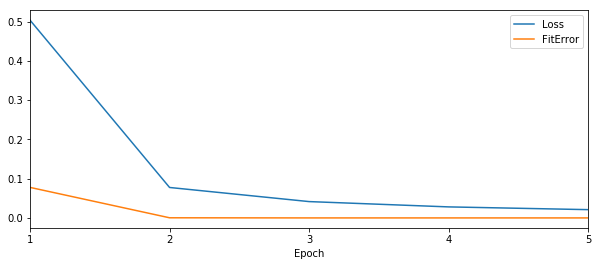

In [16]:
# Plot the Training and Validation Error
fruit_model_resnet.plot_training_history(fig_size=(10,4), items=('Loss','FitError'))

In [17]:
# Predict Test Data Using Simple Model
simple_model.predict(test, gpu=dict(devices=[1]))

NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.


[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(anviol)  Valid_Res_53asYd   777       15   
 
                                             casTable  
 0  CASTable('Valid_Res_53asYd', caslib='CASUSER(a...  

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           777
 1  Number of Observations Used           777
 2  Misclassification Error (%)             0
 3                   Loss Error      0.000993

+ Elapsed: 2.16s, user: 2.34s, sys: 1.28s, mem: 1.8e+03mb

In [18]:
# Predict Test Data Using Common Pre-built ResNet Model
fruit_model_resnet.predict(test, gpu=dict(devices=[1]))

NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.


[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(anviol)  Valid_Res_O6RXuW   777       15   
 
                                             casTable  
 0  CASTable('Valid_Res_O6RXuW', caslib='CASUSER(a...  

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           777
 1  Number of Observations Used           777
 2  Misclassification Error (%)             0
 3                   Loss Error       0.00315

+ Elapsed: 4.15s, user: 3.82s, sys: 1.96s, mem: 772mb

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(anviol).


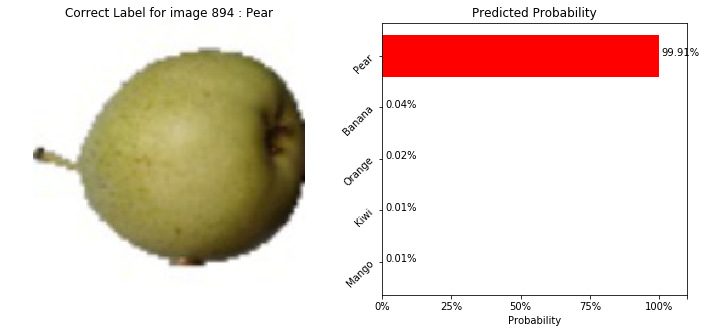

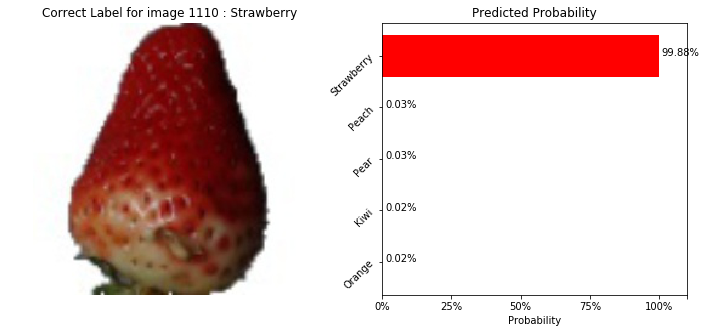

In [19]:
# Plot Predictions
fruit_model_resnet.plot_evaluate_res(img_type='C', randomize=True, n_images=2)